<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/18-reinforcement-learning/1_introduction_to_open_ai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Network Policies

One of the challenges of Reinforcement Learning is that in order to train an agent, you first need to have a working environment. If you want to program an agent that will learn to play an Atari game, you will need an Atari game simulator. If you want to program a walking robot, then the environment is the real world, and you can directly train your robot in that environment, 

But this has its limits: if the robot falls off a cliff, you can’t just click Undo. You can’t speed up time either; adding more computing power won’t make the robot move any faster. And it’s generally too expensive to train 1,000 robots in parallel. In short, training is hard and slow in the real world,
so you generally need a simulated environment at least for bootstrap training.

[OpenAI Gym](https://gym.openai.com/) is a toolkit that provides a wide variety of simulated environments (Atari games, board games, 2D and 3D physical simulations, and so on), so you can train agents, compare them, or develop new RL algorithms.

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

## Introduction to OpenAI gym

OpenAI gym, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with. Let's start by importing gym:

In [0]:
import gym

Let's list all the available environments:

In [0]:
gym.envs.registry.all()

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [0]:
env = gym.make('CartPole-v1')

Let's initialize the environment by calling is reset() method. This returns an observation:

In [4]:
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

Observations vary depending on the environment. In this case it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its render() method, and you can pick the rendering mode (the rendering options depend on the environment).

> **Warning**: some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify mode="rgb_array". In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. 

On Debian or Ubuntu:

```python
$ apt update
$ apt install -y xvfb
```

You can then start Jupyter using the xvfb-run command:

```python
$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
```

Alternatively, you can install the [pyvirtualdisplay](https://github.com/ponty/pyvirtualdisplay) Python library which wraps Xvfb:

```python
python3 -m pip install -U pyvirtualdisplay
```

And run the following code:

In [5]:
try:
  import pyvirtualdisplay
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
  pass

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [6]:
env.render()

True

In this example we will set mode="rgb_array" to get an image of the environment as a NumPy array:

In [7]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [0]:
def plot_environment(env, figsize=(5, 4)):
  plt.figure(figsize=figsize)
  img = env.render(mode="rgb_array")
  plt.imshow(img)
  plt.axis("off")
  return img

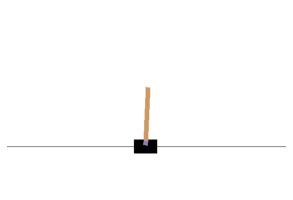

In [9]:
plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). 

Let’s ask the environment what actions are possible:

In [10]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [11]:
action = 1   # accelerate right
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

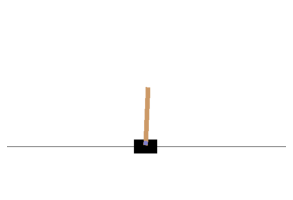

In [12]:
plot_environment(env)
plt.show()

Looks like it's doing what we're telling it to do!

The step() method executes the given action and returns four values:

* **obs** : This is the new observation. The cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

* **reward**: In this environment, you get a reward of 1.0 at every step, no matter what you do, so the goal is to keep the episode running as long as possible.

* **done**: This value will be True when the episode is over. This will happen when the pole tilts too much, or goes off the screen, or after 200 steps (in this last case, you have won). After that, the environment must be reset before it can be used again.

* **info**: This environment-specific dictionary can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [13]:
# The environment also tells the agent how much reward it got during the last step
reward

1.0

In [14]:
# When the game is over, the environment returns done=True
done

False

In [15]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when step() returns done=True), you should reset the environment before you continue to use it.

In [0]:
if done:
  obs = env.reset()

Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

## A simple hard-coded policy

Let’s hardcode a simple policy that accelerates left when the pole is leaning toward the left and accelerates right when the pole is leaning toward the right. We will run this policy to see the average rewards it gets over 500 episodes:

In [0]:
env.seed(42)

def basic_policy(obs):
  angle = obs[2]
  return 0 if angle < 0 else 1

totals = []
for episode in range(500):
  episode_rewards = 0
  obs = env.reset()
  for step in range(200):
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    episode_rewards += reward
    if done:
      break
  totals.append(episode_rewards)

In [18]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 68 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [0]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation:

In [0]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [21]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

Let’s see if a neural network can come up with a better policy.

## Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/nn-policy.png?raw=1' width='800'/>

 In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

For example, if it outputs 0.7, then we will pick action 0 with 70% probability, or action 1 with 30% probability.



In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4  # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')                          
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. **This approach lets the agent find the right balance between exploring new actions and exploiting the actions that are known to work well**. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [0]:
def render_policy_net(model, n_max_steps=200, seed=42):
  frames = []
  env = gym.make('CartPole-v1')
  env.seed(seed)
  np.random.seed(seed)
  obs = env.reset()

  for step in range(n_max_steps):
    frames.append(env.render(mode='rgb_array'))
    left_proba = model.predict(obs.reshape(1, -1))
    action = int(np.random.rand() > left_proba)
    obs, reward, done, info = env.step(action)
    if done:
      break;
  env.close()
  return frames

Now let's look at how well this randomly initialized policy network performs:

In [24]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [25]:
n_environments = 50
n_iterations = 5000

envs = [gym.make('CartPole-v1') for _ in range(n_environments)]
for index, env in enumerate(envs):
  env.seed(index)
np.random.seed(42)

observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
  # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
  target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
  with tf.GradientTape() as tape:
    left_probas = model(np.array(observations))
    loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
  print('\rIteration: {}, Loss: {:.3f}'.format(iteration, loss.numpy()), end='')

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)

  for env_index, env in enumerate(envs):
    obs, reward, done, info = env.step(actions[env_index][0])
    observations[env_index] = obs if not done else env.reset()

for env in envs:
  env.close()

Iteration: 4999, Loss: 0.094

In [26]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

## Policy Gradients

To train this neural network we will need to define the target probabilities y. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? **This is called the credit assignment problem**.

The Policy Gradients algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/action-return.png?raw=1' width='800'/>

PG algorithms optimize the parameters of a policy by following the gradients toward higher rewards. One popular class of PG algorithms, called REINFORCE algorithms.

1. First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely—but don’t apply these gradients yet.
2. Once you have run several episodes, compute each action’s advantage.
3. If an action’s advantage is positive, it means that the action was probably good, and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action’s advantage is negative, it means the action was probably bad, and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is simply to multiply each gradient vector by the corresponding action’s advantage.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step.


Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [0]:
def play_one_step(env, obs, model, loss_fn):
  with tf.GradientTape() as tape:
    left_proba = model(obs[np.newaxis])
    action = (tf.random.uniform([1, 1]) > left_proba)
    y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
    loss = tf.reduce_mean(loss_fn(y_target, left_proba))
  grads = tape.gradient(loss, model.trainable_variables)
  obs, reward, done, info = env.step(int(action[0, 0].numpy()))

  return obs, reward, done, grads

If left_proba is high, then action will most likely be False (since a random number uniformally sampled between 0 and 1 will probably not be greater than left_proba). And False means 0 when you cast it to a number, so y_target would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the play_one_step() function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [0]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
  all_rewards = []
  all_grads = []
  for episode in range(n_episodes):
    current_rewards = []
    current_grads = []
    obs = env.reset()
    for step in range(n_max_steps):
      obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
      current_rewards.append(reward)
      current_grads.append(grads)
      if done:
        break
    all_rewards.append(current_rewards)
    all_grads.append(current_grads)

  return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [0]:
def discount_rewards(rewards, discount_rate):
  discounted = np.array(rewards)
  for step in range(len(rewards) - 2, -1, -1):
    discounted[step] += discounted[step + 1] * discount_rate

  return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
  all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
  flat_rewards = np.concatenate(all_discounted_rewards)
  reward_mean = flat_rewards.mean()
  reward_std = flat_rewards.std()

  return [(discount_rewards - reward_mean) / reward_std for discount_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50(as shown above image). If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [31]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [32]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Notice that the first episode was much worse than the second, so its normalized advantages are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good.

We are almost ready to run the algorithm! Now let’s define the hyperparameters. We will run 150 training iterations, playing 10 episodes per iteration, and each episode will last at most 200 steps. We will use a discount factor of 0.95:

In [0]:
n_iterations = 50
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

We also need an optimizer and the loss function. A regular Adam optimizer with
learning rate 0.01 will do just fine, and we will use the binary cross-entropy loss function because we are training a binary classifier(there are two possible actions: left or right)

In [0]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
   keras.layers.Dense(5, activation='elu', input_shape=[4]),
   keras.layers.Dense(1, activation='sigmoid')
])

We are now ready to build and run the training loop!

In [38]:
env = gym.make('CartPole-v1')
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 49, mean rewards: 182.4

In [39]:
frames = render_policy_net(model)
plot_animation(frames)

And we’re done! This will train the neural network policy, and it will successfully learn to balance the pole on the cart. The mean reward per episode will get very close to 200 (which is the maximum by default with this environment). Success!

The simple policy gradients algorithm we just trained solved the CartPole task, but it would not scale well to larger and more complex tasks. Indeed, it is highly sample inefficient, meaning it needs to explore the game for a very long time before it can make significant progress. This is due to the fact that it must run multiple episodes to estimate the advantage of each action, as we have seen. However, it is the foundation of more powerful algorithms, such as Actor-Critic algorithms.

We will now look at another popular family of algorithms. Whereas PG algorithms
directly try to optimize the policy to increase rewards, the algorithms we will look at now are less direct:the agent learns to estimate the expected return for each state, or for each action in each state, then it uses this knowledge to decide how to act. **To understand these algorithms, we must first introduce Markov decision processes.**